In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
import math
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from autogluon.tabular import TabularDataset, TabularPredictor

# Importing *train* and *test* datasets

In [2]:
train = pd.read_csv('/Users/mariachen/Desktop/mmf-data-science-2022/train.csv')
train.head(5)

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,1.01,Very Good,E,SI2,60.0,60.0,4540,6.57,6.49,3.92
1,1,1.10,Premium,H,VS2,62.5,58.0,5729,6.59,6.54,4.10
2,2,1.50,Good,E,SI2,61.5,65.0,6300,7.21,7.17,4.42
3,3,1.53,Premium,E,SI1,61.3,59.0,12968,7.40,7.35,4.52
4,4,0.84,Fair,D,SI2,64.5,60.0,2167,5.92,5.84,3.79


In [3]:
test = pd.read_csv('/Users/mariachen/Desktop/mmf-data-science-2022/test.csv')
test.head(5)

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.24,Ideal,G,VVS1,62.1,56.0,3.97,4.00,2.47
1,1,1.21,Very Good,F,VS2,62.9,54.0,6.78,6.82,4.28
2,2,0.50,Fair,E,SI1,61.7,68.0,5.09,5.03,3.12
3,3,0.50,Ideal,D,SI2,62.8,56.0,5.06,5.03,3.17
4,4,1.55,Ideal,E,SI2,62.3,55.0,7.44,7.37,4.61


In [4]:
#Creating a copy of the train and test datasets

c_test  = test.copy()
c_train  = train.copy()

# Getting information about train dataset

In [5]:
c_train.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,1.01,Very Good,E,SI2,60.0,60.0,4540,6.57,6.49,3.92
1,1,1.10,Premium,H,VS2,62.5,58.0,5729,6.59,6.54,4.10
2,2,1.50,Good,E,SI2,61.5,65.0,6300,7.21,7.17,4.42
3,3,1.53,Premium,E,SI1,61.3,59.0,12968,7.40,7.35,4.52
4,4,0.84,Fair,D,SI2,64.5,60.0,2167,5.92,5.84,3.79


In [6]:
c_train.describe()

,id,carat,depth,table,price,x,y,z
count,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000
mean,21576.500000,0.799047,61.742925,57.459010,3946.777054,5.733798,5.737574,3.539338
std,12457.631095,0.475214,1.428410,2.227191,3998.657385,1.123004,1.150325,0.696203
min,0.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.250000,0.400000,61.000000,56.000000,953.000000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2406.500000,5.700000,5.710000,3.530000
75%,32364.750000,1.040000,62.500000,59.000000,5367.000000,6.540000,6.540000,4.040000
max,43153.000000,4.500000,79.000000,79.000000,18823.000000,10.230000,58.900000,8.060000


Our target variable is price of diamonds. Id is just an index that we can drop but we will need it in the final submission.

In [7]:
# Concat Train and Test datasets

c_train['train']  = 1
c_test['train']  = 0
df = pd.concat([c_train, c_test], axis=0,sort=False)

# Data preprocessing

## Calculating the percentage of missing values of each feature

In [8]:
#Percentage of NAN Values 
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

In [9]:
NAN

,column_name,percentage
0,id,0.000000
1,carat,0.000000
2,cut,0.000000
3,color,0.000000
4,clarity,0.000000
5,depth,0.000000
6,table,0.000000
7,price,20.000742
8,x,0.000000
9,y,0.000000


So our dataset is pretty clean without null values.

Now we will select numerical and categorical features

In [10]:
object_columns_df = df.select_dtypes(include=['object'])
numerical_columns_df =df.select_dtypes(exclude=['object'])

In [11]:
object_columns_df.dtypes

cut        object
color      object
clarity    object
dtype: object

In [12]:
numerical_columns_df.dtypes

id         int64
carat    float64
depth    float64
table    float64
price    float64
x        float64
y        float64
z        float64
train      int64
dtype: object

## Check our categorical variables 

G    11292
E     9799
F     9543
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

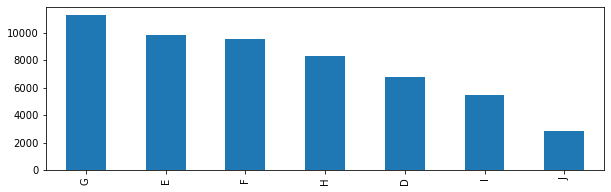

In [13]:
object_columns_df['color'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['color'].value_counts() 

SI1     13067
VS2     12259
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

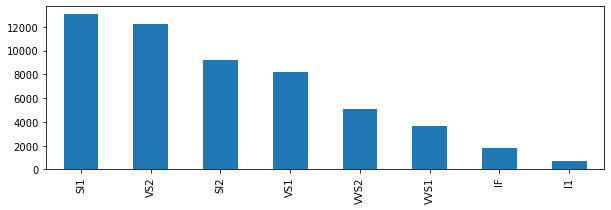

In [14]:
object_columns_df['clarity'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['clarity'].value_counts() 

Ideal        21551
Premium      13793
Very Good    12083
Good          4906
Fair          1610
Name: cut, dtype: int64

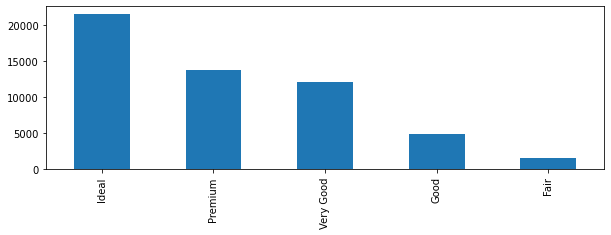

In [15]:
object_columns_df['cut'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['cut'].value_counts() 

## Now the next step is to encode categorical features

In [16]:
cut = {"Ideal" : 5, "Premium" : 4, "Very Good" : 3, "Good" : 2, "Fair" : 1}
object_columns_df['cut'] = object_columns_df['cut'].map(cut)

In [17]:
clarity = {"IF" : 8, "VVS1" : 7, "VVS2" : 6, "VS1" : 5, "VS2" : 4, "SI1" : 3, "SI2" : 2, "I1" : 1}
object_columns_df['clarity'] = object_columns_df['clarity'].map(clarity)

In [18]:
color = {"D" : 7, "E" : 6, "F" : 5, "G" : 4, "H" : 3, "I" : 2, "J" : 1}
object_columns_df['color'] = object_columns_df['color'].map(color)

In [19]:
#Select categorical features
rest_object_columns = object_columns_df.select_dtypes(include=['object'])
#Using One hot encoder
object_columns_df = pd.get_dummies(object_columns_df, columns=rest_object_columns.columns) 

In [20]:
object_columns_df.head()

,cut,color,clarity
0,3,6,2
1,4,3,4
2,2,6,2
3,4,6,3
4,1,7,2


## Concat Categorical (after encoding) and numerical features

In [21]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,cut,color,clarity,id,carat,depth,table,price,x,y,z,train
0,3,6,2,0,1.01,60.0,60.0,4540.0,6.57,6.49,3.92,1
1,4,3,4,1,1.10,62.5,58.0,5729.0,6.59,6.54,4.10,1
2,2,6,2,2,1.50,61.5,65.0,6300.0,7.21,7.17,4.42,1
3,4,6,3,3,1.53,61.3,59.0,12968.0,7.40,7.35,4.52,1
4,1,7,2,4,0.84,64.5,60.0,2167.0,5.92,5.84,3.79,1


In [22]:
df_final = df_final.drop(['id',],axis=1)

df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['price'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [23]:
df_train

,cut,color,clarity,carat,depth,table,price,x,y,z
0,3,6,2,1.01,60.0,60.0,4540.0,6.57,6.49,3.92
1,4,3,4,1.10,62.5,58.0,5729.0,6.59,6.54,4.10
2,2,6,2,1.50,61.5,65.0,6300.0,7.21,7.17,4.42
3,4,6,3,1.53,61.3,59.0,12968.0,7.40,7.35,4.52
4,1,7,2,0.84,64.5,60.0,2167.0,5.92,5.84,3.79
...,...,...,...,...,...,...,...,...,...,...
43149,3,2,4,1.05,62.4,59.0,4975.0,6.48,6.51,4.05
43150,5,7,5,0.47,61.0,55.0,1617.0,5.03,5.01,3.06
43151,3,5,8,0.33,60.3,58.0,1014.0,4.49,4.46,2.70
43152,4,1,3,0.90,62.8,59.0,2871.0,6.13,6.03,3.82


In [24]:
df_test

,cut,color,clarity,carat,depth,table,x,y,z
0,5,4,7,0.24,62.1,56.0,3.97,4.00,2.47
1,3,5,4,1.21,62.9,54.0,6.78,6.82,4.28
2,1,6,3,0.50,61.7,68.0,5.09,5.03,3.12
3,5,7,2,0.50,62.8,56.0,5.06,5.03,3.17
4,5,6,2,1.55,62.3,55.0,7.44,7.37,4.61
...,...,...,...,...,...,...,...,...,...
10784,5,5,4,0.53,62.3,55.0,5.20,5.17,3.23
10785,4,4,3,0.41,61.3,60.0,4.75,4.81,2.93
10786,4,4,4,0.51,62.4,58.0,5.11,5.12,3.19
10787,2,1,2,1.08,63.2,59.0,6.40,6.57,4.10


## Distribution of Price

(array([20249.,  7402.,  5909.,  3129.,  1908.,  1401.,  1067.,   820.,
          688.,   581.]),
 array([  326. ,  2175.7,  4025.4,  5875.1,  7724.8,  9574.5, 11424.2,
        13273.9, 15123.6, 16973.3, 18823. ]),
 <BarContainer object of 10 artists>)

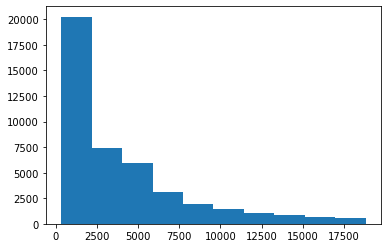

In [25]:
plt.hist(df_train['price'])

## Check for Correlations

In [26]:
corr = df_final.corr()
corr

,cut,color,clarity,carat,depth,table,price,x,y,z,train
cut,1.000000,0.020506,0.189171,-0.134964,-0.218037,-0.433387,-0.053291,-0.125564,-0.121461,-0.149320,0.001833
color,0.020506,1.000000,-0.025646,-0.291439,-0.047316,-0.026457,-0.171962,-0.270281,-0.263579,-0.268226,0.001062
clarity,0.189171,-0.025646,1.000000,-0.352833,-0.067355,-0.160328,-0.145394,-0.371996,-0.358417,-0.366946,0.005206
carat,-0.134964,-0.291439,-0.352833,1.000000,0.028234,0.181602,0.921273,0.975093,0.951721,0.953387,0.004692
depth,-0.218037,-0.047316,-0.067355,0.028234,1.000000,-0.295798,-0.009905,-0.025289,-0.029340,0.094927,-0.008930
table,-0.433387,-0.026457,-0.160328,0.181602,-0.295798,1.000000,0.124965,0.195333,0.183750,0.150915,0.001574
price,-0.053291,-0.171962,-0.145394,0.921273,-0.009905,0.124965,1.000000,0.884983,0.861052,0.874976,NaN
x,-0.125564,-0.270281,-0.371996,0.975093,-0.025289,0.195333,0.884983,1.000000,0.974701,0.970771,0.004708
y,-0.121461,-0.263579,-0.358417,0.951721,-0.029340,0.183750,0.861052,0.974701,1.000000,0.952005,0.005337
z,-0.149320,-0.268226,-0.366946,0.953387,0.094927,0.150915,0.874976,0.970771,0.952005,1.000000,0.001724


<AxesSubplot:>

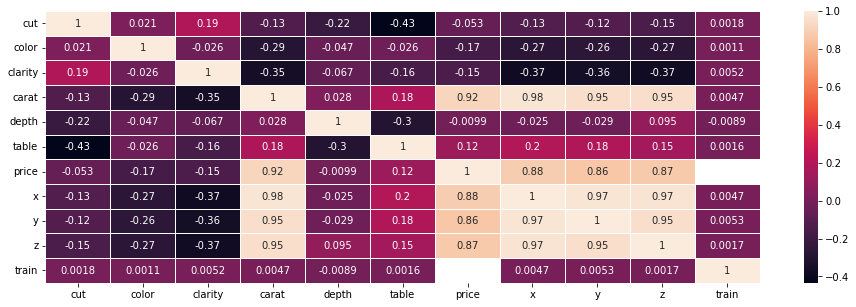

In [27]:
plt.figure(figsize = (16,5))
sns.heatmap(corr,annot=True,lw=1)

From the above plot, we can see that x, y and z are strongly correlated to one another. Meanwhile, x, y and z are also related to carat of the diamonds. These four variables have high correlation with price of diamonds. 

In [37]:
from sklearn.decomposition import PCA
df_st =  StandardScaler().fit_transform(df_train)  
pd.DataFrame(df_st, columns=df_train.columns).head(2)

,cut,color,clarity,carat,depth,table,price,x,y,z
0,-0.811526,0.936117,-1.249802,0.443917,-1.220200,1.140908,0.148357,0.744620,0.654106,0.546775
1,0.085082,-0.826567,-0.033608,0.633308,0.530018,0.242905,0.445711,0.762429,0.697573,0.805323


In [40]:
pca_out = PCA().fit(df_st)
np.cumsum(pca_out.explained_variance_ratio_)

array([0.50198894, 0.64590854, 0.76921789, 0.86797067, 0.94516574,
       0.98086405, 0.99344758, 0.99738296, 0.9993432 , 1.        ])

In [42]:
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_train.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
variable,,,,,,,,,,
cut,-0.083775,-0.624479,0.391528,-0.215056,-0.246125,0.584325,0.036927,-0.002378,0.008766,-0.002476
color,-0.136893,0.151324,0.045195,-0.814648,0.525657,0.025735,0.106207,-0.042449,0.050860,-0.004601
clarity,-0.179679,-0.273581,0.223362,0.500451,0.733318,0.010396,0.218225,-0.063648,0.054682,0.000594
carat,0.440199,-0.060982,0.006891,-0.007271,0.045884,0.005828,-0.156314,-0.334871,0.799060,-0.158732
depth,0.007692,-0.143904,-0.835809,0.045978,0.161242,0.491077,0.021069,0.057132,0.024351,0.084174
table,0.106160,0.678371,0.283271,0.181903,0.058304,0.641388,0.010797,0.016322,-0.006955,-0.001919
price,0.402964,-0.138395,0.090289,-0.022223,0.302587,0.021823,-0.755169,0.253848,-0.286850,0.028003
x,0.440901,-0.044190,0.045263,-0.037497,0.015867,-0.031765,0.238518,-0.362854,-0.203224,0.754377
y,0.433225,-0.049527,0.049112,-0.038851,0.020636,-0.056943,0.447459,0.758771,0.162202,0.003375


In [29]:
y= df_train['price']
X = df_train.drop(['price'],axis=1)

# Modelling (Linear Regression)

In [30]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=101)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25892, 9)
(17262, 9)
(25892,)
(17262,)


In [31]:
linear_regression_model = LinearRegression().fit(x_train, y_train)
linear_regression_model.score(x_train, y_train)

0.9056093493706977

In [32]:
predict_lr_train = linear_regression_model.predict(x_train)
predict_lr_test = linear_regression_model.predict(x_test)

In [33]:
print('Root Mean Square Error train for linear regression = ' + str(math.sqrt(metrics.mean_squared_error(y_train, predict_lr_train))))
print('Root Mean Square Error test for linear regression = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict_lr_test))))

Root Mean Square Error train for linear regression = 1234.0166443041733
Root Mean Square Error test for linear regression = 1211.1831039902472


In [34]:
c = LinearRegression().fit(X, y)
linear_regression_model.predict(X)

array([4958.80178809, 5897.5169829 , 9306.78037589, ..., 2134.78548375,
       2934.33295507, 6458.65184981])

In [35]:
y

0         4540.0
1         5729.0
2         6300.0
3        12968.0
4         2167.0
          ...   
43149     4975.0
43150     1617.0
43151     1014.0
43152     2871.0
43153     6320.0
Name: price, Length: 43154, dtype: float64

# Lasso

In [36]:
lasso = Lasso(max_iter=10000).fit(x_train,y_train)

In [37]:
lasso.score(x_train,y_train)

0.905585985284599

In [38]:
predict_lasso_train = lasso.predict(x_train)
predict_lasso_test = lasso.predict(x_test)

In [39]:
print('Root Mean Square Error train for lasso = ' + str(math.sqrt(metrics.mean_squared_error(y_train, predict_lasso_train))))
print('Root Mean Square Error test for lasso = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict_lasso_test))))

Root Mean Square Error train for lasso = 1234.1693601028799
Root Mean Square Error test for lasso = 1210.6390463747528


# Linear Support Vector Machine

In [40]:
sc_x = StandardScaler()
sc_y = StandardScaler()
xx = sc_x.fit_transform(x_train)
yy = sc_y.fit_transform(y_train.array.reshape(-1, 1))

xxx = sc_x.fit_transform(x_test)
yyy = sc_y.fit_transform(y_test.array.reshape(-1, 1))

In [41]:
lsvr_standardized = LinearSVR(verbose=0, max_iter=100000)
lsvr_standardized.fit(xx, yy.ravel())
predict_lsvr_train = lsvr_standardized.predict(xx)
predict_lsvr_test = lsvr_standardized.predict(xxx)

In [42]:
print('Root Mean Square Error train for LSVR = ' +
      str(math.sqrt(metrics.mean_squared_error(y_train, sc_y.inverse_transform(predict_lsvr_train.reshape(-1, 1))))))
print('Root Mean Square Error test for LSVR = ' +
      str(math.sqrt(metrics.mean_squared_error(y_test, sc_y.inverse_transform(predict_lsvr_test.reshape(-1, 1))))))

Root Mean Square Error train for LSVR = 1369.7524823434383
Root Mean Square Error test for LSVR = 1357.8650248404892


# Support Vector Machine with "RBF" Kernel

In [43]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
rbf = svr_rbf.fit(xx, yy.ravel())

In [44]:
predict_svr_rbf_train = rbf.predict(xx)
predict_svr_rbf_test = rbf.predict(xxx)

In [45]:
print('Root Mean Square Error train for SVR_RBF = ' +
      str(math.sqrt(metrics.mean_squared_error(y_train, sc_y.inverse_transform(predict_svr_rbf_train.reshape(-1, 1))))))
print('Root Mean Square Error test for SVR_RBF = ' +
      str(math.sqrt(metrics.mean_squared_error(y_test, sc_y.inverse_transform(predict_svr_rbf_test.reshape(-1, 1))))))

Root Mean Square Error train for SVR_RBF = 504.08990764478335
Root Mean Square Error test for SVR_RBF = 655.7986363675918


# Support Vector Machine with "Poly" Kernel

In [46]:
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
poly = svr_poly.fit(xx, yy.ravel())

In [47]:
predict_svr_poly_train = poly.predict(xx)
predict_svr_poly_test = poly.predict(xxx)

In [48]:
print('Root Mean Square Error train for SVR_Poly = ' +
      str(math.sqrt(metrics.mean_squared_error(y_train, sc_y.inverse_transform(predict_svr_poly_train.reshape(-1, 1))))))
print('Root Mean Square Error test for SVR_Poly = ' +
      str(math.sqrt(metrics.mean_squared_error(y_test, sc_y.inverse_transform(predict_svr_poly_test.reshape(-1, 1))))))

Root Mean Square Error train for SVR_Poly = 626.5357796327293
Root Mean Square Error test for SVR_Poly = 36861.61040823768


In [ ]:
sc_y.inverse_transform(y)